### Import Starter Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Load Data

In [2]:
# import the training set and assign it to 'df'
df = pd.read_csv('../datasets/train.csv')
# import the holdout set and assign it to 'holdout'
holdout = pd.read_csv('../datasets/test.csv')

### EDA and Cleaning

In [3]:
# display the shape of the training data
df.shape

(2051, 81)

The training dataset contains 2,051 rows (each represents a house sold) and 81 columns (each represents a feature, or characteristic of the house).

In [4]:
# # display the shape of the holdout data
holdout.shape

(879, 80)

The holdout dataset contains 879 rows and 80 columns. The target column, sales price, has been removed from the holdout dataset.

Together, the testing and holdout sets describe 2,930 houses; these have been split so that 70 percent are in the training set and 30 percent are in the holdout set.

In [5]:
# display the first 5 rows of the training data using df.head()
df.head()

Id        PID  MS SubClass MS Zoning  Lot Frontage  Lot Area Street Alley  \
0  109  533352170           60        RL           NaN     13517   Pave   NaN   
1  544  531379050           60        RL          43.0     11492   Pave   NaN   
2  153  535304180           20        RL          68.0      7922   Pave   NaN   
3  318  916386060           60        RL          73.0      9802   Pave   NaN   
4  255  906425045           50        RL          82.0     14235   Pave   NaN   

  Lot Shape Land Contour  ... Screen Porch Pool Area Pool QC Fence  \
0       IR1          Lvl  ...            0         0     NaN   NaN   
1       IR1          Lvl  ...            0         0     NaN   NaN   
2       Reg          Lvl  ...            0         0     NaN   NaN   
3       Reg          Lvl  ...            0         0     NaN   NaN   
4       IR1          Lvl  ...            0         0     NaN   NaN   

  Misc Feature Misc Val Mo Sold Yr Sold  Sale Type  SalePrice  
0          NaN        0       3    2010        WD      130500  
1          NaN        0       4    2009        WD      220000  
2          NaN        0       1    2010        WD      109000  
3          NaN        0       4    2010        WD      174000  
4          NaN        0       3    2010        WD      138500  

[5 rows x 81 columns]

Each house is described in great detail. It will take some investigation to determine the extent to which each feature can be used in developing a predictive model.

#### Rename Columns

Before I work with columns, I like to rename them to eliminate capital letters and replace spaces with underscores. For me, this makes it easier to work with the data.

In [6]:
# replace spaces in column names with underscores
# and convert all to lowercase
df.columns = [x.replace(" ", "_").lower() for x in df.columns]
holdout.columns = [x.replace(" ", "_").lower() for x in holdout.columns]

#### Check Missingness and Datatypes

In [7]:
# investigate general information about the dataset using df.info()
# this includes inormation on the number of nulls in each column
# and the datatype of each column.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 81 columns):
id                 2051 non-null int64
pid                2051 non-null int64
ms_subclass        2051 non-null int64
ms_zoning          2051 non-null object
lot_frontage       1721 non-null float64
lot_area           2051 non-null int64
street             2051 non-null object
alley              140 non-null object
lot_shape          2051 non-null object
land_contour       2051 non-null object
utilities          2051 non-null object
lot_config         2051 non-null object
land_slope         2051 non-null object
neighborhood       2051 non-null object
condition_1        2051 non-null object
condition_2        2051 non-null object
bldg_type          2051 non-null object
house_style        2051 non-null object
overall_qual       2051 non-null int64
overall_cond       2051 non-null int64
year_built         2051 non-null int64
year_remod/add     2051 non-null int64
roof_style         20

In [8]:
# check the total number of null values in the dataset
print('total null values\n---------\ntraining set: ', df.isnull().sum().sum())
print('holdout set: ', holdout.isnull().sum().sum())

total null values
---------
training set:  9822
holdout set:  4175


#### Two key takeaways from this:

1. There are many null values, which will throw errors during modeling if they're not addressed. 

2. 42 of the columns in the training dataset are stored as objects, which will need to be changed to numeric types, if possible, in order to be used in modeling.

#### Null Values

I will have to systematically go through the columns with nulls to address them, so I will define a simple function to display all of the nulls in descending order (most nulls shown first) by calling the function on the dataframe.

In [9]:
# define a function to return all the null values in descending order
def check_nulls(dataframe):
    nulls = dataframe.isnull().sum().sort_values(ascending=False)
    return nulls[nulls > 0]

In [10]:
# display the number of nulls for all columns with nulls
check_nulls(df)

pool_qc           2042
misc_feature      1986
alley             1911
fence             1651
fireplace_qu      1000
lot_frontage       330
garage_finish      114
garage_cond        114
garage_qual        114
garage_yr_blt      114
garage_type        113
bsmt_exposure       58
bsmtfin_type_2      56
bsmtfin_type_1      55
bsmt_cond           55
bsmt_qual           55
mas_vnr_type        22
mas_vnr_area        22
bsmt_half_bath       2
bsmt_full_bath       2
garage_cars          1
garage_area          1
bsmt_unf_sf          1
bsmtfin_sf_2         1
total_bsmt_sf        1
bsmtfin_sf_1         1
dtype: int64

In [11]:
# check nulls on the holdout set
check_nulls(holdout)

pool_qc           875
misc_feature      838
alley             821
fence             707
fireplace_qu      422
lot_frontage      160
garage_cond        45
garage_qual        45
garage_yr_blt      45
garage_finish      45
garage_type        44
bsmt_exposure      25
bsmtfin_type_1     25
bsmt_qual          25
bsmtfin_type_2     25
bsmt_cond          25
mas_vnr_area        1
mas_vnr_type        1
electrical          1
dtype: int64

Some of these columns have huge portions which are null values. In order to get a better sense of which columns I might want to drop entirely, I'd also like to see the number of nulls as a percentage of the total observations.

In [12]:
# display the percentage of nulls for all columns with null percentage over 25%
nulls = df.isnull().sum().sort_values(ascending=False)
nulls[nulls / df.shape[0] > 0.25] / df.shape[0]

pool_qc         0.995612
misc_feature    0.968308
alley           0.931741
fence           0.804973
fireplace_qu    0.487567
dtype: float64

These five features seem to be missing data for more than 25 percent of their observations, making them candidates to be dropped entirely. However, the data dictionary suggests that an NA value for these categories means that the specified feature is missing from the home (e.g. a home with an NA for pool_qc does not have a pool), so it may be wrong to treat these as missing data. A few options exist:

1. *Drop the columns entirely*
2. *Impute values of zero where the feature is specified as ordinal (pool_qc, alley, fence, fireplace_qu)*
3. *Binarize the columns that indicate the presence or non-presence of the feature (e.g. impute a 1 if the property has a pool and a 0 if it doesn't have a pool)*

In the interest of simplicity, I'm going to drop the four columns with greater than 80% null values. In the future it would be interesting to reconsider this for some or all of these columns.

I'll also have to drop these from the holdout set, since the model will expect the number of input features to be the same when applied to the holdout set.

In [13]:
# define the columns to drop
# I'll also drop 'pid' since it's an arbitrary identification number
drop_columns = ['pool_qc', 'misc_feature', 'alley', 'fence', 'pid']

# drop columns with over 80% null values in the training and holdout sets
df.drop(columns=drop_columns, inplace=True)
holdout.drop(columns=drop_columns, inplace=True)

Before looking at the remaining null values directly, I will move on with converting the non-numeric columns, since this will address many of the "nulls" (which actually represent non-existent features, not missing data).

#### Converting Non-Numeric Columns (Ordinal Values to Scale)

Based on the data dictionary, many of the non_numeric columns have ordinal values. For example, the column describing basement quality (basement height) includes the following values:    
   
   - Ex   Excellent (100+ inches) 
   - Gd   Good (90-99 inches)
   - TA   Typical (80-89 inches)
   - Fa   Fair (70-79 inches)
   - Po   Poor (&lt;70 inches
   - NA   No Basement 

Thus I will assign numerical values to these ratings, such that "Ex" is converted to 5, "Gd" is converted to 4, and so on through to "NA" being assigned to 0. This should have the secondary benefit of removing some of the remaining null values from these columns.

In [14]:
# define a function to convert the ordinal columns 
# with the Ex-Gd-TA-Fa-Po-NA scale to numeric
def ex_scale(df, column_list):
    for column in column_list:
        # replace ordinal objects with ordinal numbers
        df[column] = df[column].map({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0})
        # convert columns from object to numeric datatype
        df[column] = pd.to_numeric(df[column])
        # replace null values with 0
        df[column] = df[column].fillna(0)

In [15]:
# run the ex_scale function on the appropriate ordinal columns
column_list = ['bsmt_qual', 
               'bsmt_cond',
               'exter_qual',
               'exter_cond',
               'fireplace_qu',
               'garage_qual',
               'garage_cond',
               'heating_qc',
               'kitchen_qual']
ex_scale(df, column_list)
ex_scale(holdout, column_list)

Additional ordinal characterstics specified in the data dictionary have to be converted in a more piecemeal fashion:

In [16]:
# define a function to streamline the process and apply the changes
# to both the testing and the holdout sets
def var_scale(column, reassign_dict, data_set_list = [df, holdout]):
    for data_set in data_set_list:
        data_set[column] = pd.to_numeric(data_set[column].map(reassign_dict))
        data_set[column] = data_set[column].fillna(0)
        #print(data_set[column].value_counts().sum())     
        

In [17]:
# convert additional ordinal characteristics
var_scale('lot_shape', {'Reg': 3, 'IR1': 2, 'IR2': 1, 'IR3': 0})
var_scale('utilities', {'AllPub': 3, 'NoSewr': 2, 'NoSeWa': 1, 'ELO': 0})
var_scale('land_slope', {'Gtl': 2, 'Mod': 1, 'Sev': 0})
var_scale('bsmt_exposure', {'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1, 'NA': 0})
var_scale('bsmtfin_type_1', {'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, 'NA': 0})
var_scale('bsmtfin_type_2', {'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, 'NA': 0})
var_scale('electrical', {'SBrkr': 4, 'FuseA': 3, 'FuseF': 2, 'FuseP': 1, 'Mix': 0})
var_scale('functional', {'Typ': 7, 'Min1': 6, 'Min2': 5, 'Mod': 4, 'Maj1': 3, 'Maj2': 2, 'Sev': 1, 'Sal': 0})
var_scale('garage_finish', {'Fin': 3, 'Rfn': 2, 'Unf': 1})
var_scale('paved_drive', {'Y': 2, 'P': 1, 'N': 0})

In [18]:
# convert binary 'central_air' column to 1 for yes, 0 for no
df['central_air'] = pd.to_numeric(df.central_air.map({'Y': 1, 'N': 0}))
holdout['central_air'] = pd.to_numeric(holdout.central_air.map({'Y': 1, 'N': 0}))

#### Converting Non-Numeric Columns (Non-Ordinal Values to Dummies)

In [19]:
# create a list of the remaining non-numeric columns.
# these are the columns that could not be converted based on ordinal scales
non_ordinal_columns = [col for col in df.select_dtypes(include='object')]

In [20]:
# convert non-ordinal columns to dummies for the test set
df = pd.get_dummies(df, columns=non_ordinal_columns, drop_first=True)

# convert non-ordinal columns to dummies for the holdout set
holdout = pd.get_dummies(holdout, columns=non_ordinal_columns, drop_first=True)

In [21]:
# double check that no columns remain object type
len(df.dtypes[df.dtypes == 'object']) + len(holdout.dtypes[holdout.dtypes == 'object'])

0

All of the object type columns have been converted to numerical. All that remains is to deal with null values.

#### Re-check Nulls

In [22]:
# check nulls on test set
check_nulls(df)

lot_frontage      330
garage_yr_blt     114
mas_vnr_area       22
bsmt_full_bath      2
bsmt_half_bath      2
garage_area         1
bsmtfin_sf_1        1
total_bsmt_sf       1
bsmtfin_sf_2        1
garage_cars         1
bsmt_unf_sf         1
dtype: int64

In [23]:
# check nulls on holdout set
check_nulls(holdout)

lot_frontage     160
garage_yr_blt     45
mas_vnr_area       1
dtype: int64

Nice. Many of the nulls were addressed by converting to ordinal scales. The remaining columns can be addressed directly. I'm going to use regression to impute values for lot_frontage, but it will be easier to do so after addressing the other nulls, so I'll come back to lot_frontage last.

#### garage_yr_built Nulls

In [24]:
# take a look at the rows for which garage_yr_built is null
# to see if there are actually any garages there
garage_df = df[[col for col in df.columns if 'garage' in col]]
garage_df[(df.garage_yr_blt.isnull()) & (df.garage_qual != 0)]

Empty DataFrame
Columns: [garage_yr_blt, garage_finish, garage_cars, garage_area, garage_qual, garage_cond, garage_type_Attchd, garage_type_Basment, garage_type_BuiltIn, garage_type_CarPort, garage_type_Detchd]
Index: []

We know that a 'garage_qual' value of zero means there is no garage. Since there's no year value I can impute for houses with no garage, and there is a lot of other garage information that can contribute to the impact of the garage on the final model, I am going to drop 'garage_yr_blt'.

In [25]:
# drop garage_yr_blt from both the training set and the holdout set
df.drop(columns='garage_yr_blt', inplace=True)
holdout.drop(columns='garage_yr_blt', inplace=True)

#### mas_vnr_area Nulls

In [26]:
# take a look at the rows for which mas_vnr_area is null
masonry_df = df[[col for col in df.columns if 'mas_' in col]]
masonry_df[df.mas_vnr_area.isnull()]

mas_vnr_area  mas_vnr_type_BrkFace  mas_vnr_type_None  \
22             NaN                     0                  0   
41             NaN                     0                  0   
86             NaN                     0                  0   
212            NaN                     0                  0   
276            NaN                     0                  0   
338            NaN                     0                  0   
431            NaN                     0                  0   
451            NaN                     0                  0   
591            NaN                     0                  0   
844            NaN                     0                  0   
913            NaN                     0                  0   
939            NaN                     0                  0   
1025           NaN                     0                  0   
1244           NaN                     0                  0   
1306           NaN                     0                  0   
1430           NaN                     0                  0   
1434           NaN                     0                  0   
1606           NaN                     0                  0   
1699           NaN                     0                  0   
1815           NaN                     0                  0   
1820           NaN                     0                  0   
1941           NaN                     0                  0   

      mas_vnr_type_Stone  
22                     0  
41                     0  
86                     0  
212                    0  
276                    0  
338                    0  
431                    0  
451                    0  
591                    0  
844                    0  
913                    0  
939                    0  
1025                   0  
1244                   0  
1306                   0  
1430                   0  
1434                   0  
1606                   0  
1699                   0  
1815                   0  
1820                   0  
1941                   0

There's no values for any of the veneer types, so I will impute an area of zero for these values.

In [27]:
# replace the nulls with zeroes
df['mas_vnr_area'] = df.mas_vnr_area.fillna(value=0)

In [28]:
# take a look at the rows for which mas_vnr_area is null (holdout)
masonry_df = holdout[[col for col in holdout.columns if 'mas_' in col]]
masonry_df[holdout.mas_vnr_area.isnull()]

mas_vnr_area  mas_vnr_type_BrkFace  mas_vnr_type_CBlock  \
866           NaN                     0                    0   

     mas_vnr_type_None  mas_vnr_type_Stone  
866                  0                   0

In [29]:
# impute a value of zero for the holdout set's null value
holdout['mas_vnr_area'] = holdout.mas_vnr_area.fillna(value=0)

#### Re-check Nulls

In [30]:
# check remaining nulls for test set
check_nulls(df)

lot_frontage      330
bsmt_full_bath      2
bsmt_half_bath      2
total_bsmt_sf       1
bsmt_unf_sf         1
garage_area         1
garage_cars         1
bsmtfin_sf_2        1
bsmtfin_sf_1        1
dtype: int64

In [31]:
# check remaining nulls for holdout set
check_nulls(holdout)

lot_frontage    160
dtype: int64

#### bsmt Column Nulls

In [32]:
# locate the basement features and rows that have null values
bsmt_cols = df[[col for col in df.columns if 'bsmt' in col]]
bsmt_cols[df.bsmt_full_bath.isnull() > 0]

bsmt_qual  bsmt_cond  bsmt_exposure  bsmtfin_type_1  bsmtfin_sf_1  \
616         0.0        0.0            0.0             0.0           0.0   
1327        0.0        0.0            0.0             0.0           NaN   

      bsmtfin_type_2  bsmtfin_sf_2  bsmt_unf_sf  total_bsmt_sf  \
616              0.0           0.0          0.0            0.0   
1327             0.0           NaN          NaN            NaN   

      bsmt_full_bath  bsmt_half_bath  
616              NaN             NaN  
1327             NaN             NaN

A bsmt_qual score of zero implies there is no basement present, so zeroes can be imputed for these nulls.

In [33]:
df.loc[[616, 1327], list(bsmt_cols)] = df.loc[[616, 1327], list(bsmt_cols)].fillna(0)

In [34]:
check_nulls(df)

lot_frontage    330
garage_area       1
garage_cars       1
dtype: int64

#### garage Column Nulls

In [35]:
garage_cols = df[[col for col in df.columns if 'garage' in col]]
garage_cols[df.garage_area.isnull() > 0]

garage_finish  garage_cars  garage_area  garage_qual  garage_cond  \
1712            0.0          NaN          NaN          0.0          0.0   

      garage_type_Attchd  garage_type_Basment  garage_type_BuiltIn  \
1712                   0                    0                    0   

      garage_type_CarPort  garage_type_Detchd  
1712                    0                   1

A garage_qual value of zero implies there is no garage present, but this conflicts with the fact that there is a garage_type listed. Since there's no way of telling which of the conflicting pieces of information is correct, I'll just drop this row completely.

In [36]:
df.drop([1712], inplace=True)

In [37]:
check_nulls(df)

lot_frontage    330
dtype: int64

#### Impute Missing lot_frontage Values with Linear Regression

In [38]:
# check top correlation with lot_frontage
plt.figure(figsize = (12,12))
lot_front_corr = df.corr()['lot_frontage'].sort_values(ascending=False)
abs(lot_front_corr).head()

lot_frontage     1.000000
lot_area         0.574085
1st_flr_sf       0.463776
gr_liv_area      0.384314
totrms_abvgrd    0.362657
Name: lot_frontage, dtype: float64

<Figure size 864x864 with 0 Axes>

/Users/kevinc/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/Users/kevinc/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/kevinc/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/Users/kevinc/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/Users/kevinc/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X <

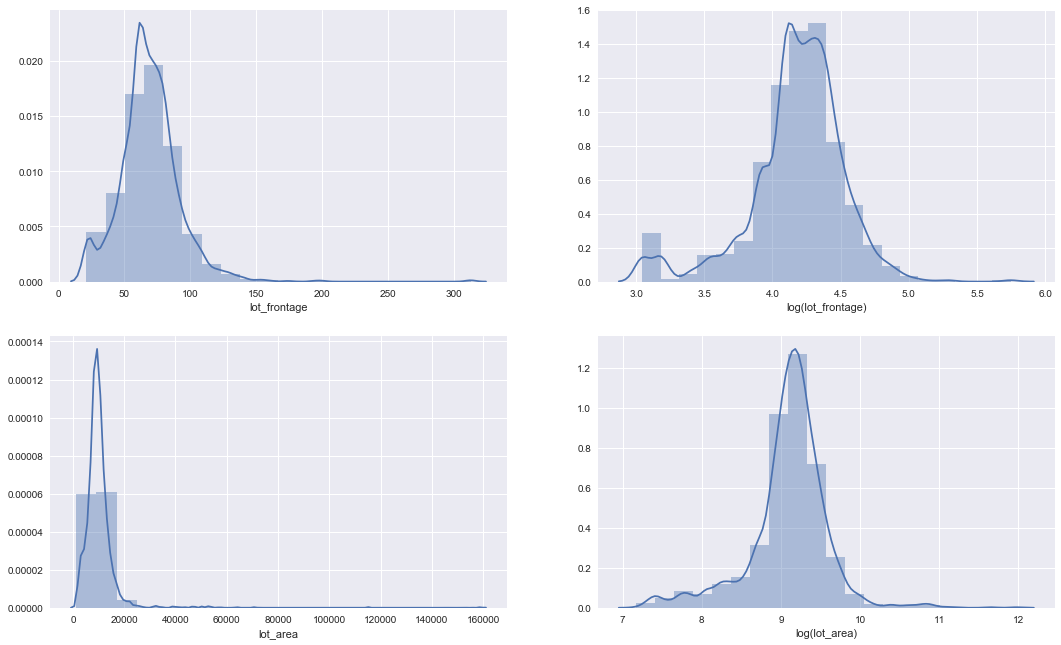

In [39]:
# look at the distributions of the target and its most highly correlated feature
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(18,11))
sns.distplot(df.lot_frontage, bins=20, ax=ax[0,0])
sns.distplot(np.log(df.lot_frontage), bins =20, ax=ax[0,1], axlabel='log(lot_frontage)')
sns.distplot(df.lot_area, bins=20, ax=ax[1,0])
sns.distplot(np.log(df.lot_area), bins =20, ax=ax[1,1], axlabel='log(lot_area)')

The log of the target, lot_area, is significantly more normal than the non-log, so I'll use the log when I train the regression.

In [40]:
# define X and y values for training based on the values that are not null
lot_not_null = df[df.lot_frontage.notnull()]
X = lot_not_null.drop(columns=['lot_frontage', 'id'])
y = np.log(lot_not_null.lot_frontage)

In [41]:
# import libraries
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.preprocessing import StandardScaler

In [42]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [43]:
# scale
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

In [44]:
# run linear regression
lr = LinearRegression()
lr.fit(X_train_sc, y_train)
print('train score: ', lr.score(X_train_sc, y_train))
print('test score: ', lr.score(X_test_sc, y_test))

train score:  0.8148317983620186
test score:  -1.248295378153235e+20


In [45]:
# run lasso regression
lasso = LassoCV(cv=10)
lasso.fit(X_train_sc, y_train)
print('train score: ', lasso.score(X_train_sc, y_train))
print('test score: ', lasso.score(X_test_sc, y_test))

train score:  0.7882349458679414
test score:  0.7531759822686407


In [46]:
# run ridge regression
ridge = RidgeCV(cv=10)
ridge.fit(X_train_sc, y_train)
print('train_score: ', ridge.score(X_train_sc, y_train))
print('test_score: ', ridge.score(X_test_sc, y_test))

train_score:  0.8137465428193953
test_score:  0.7349891890361875


Lasso has the best r2 scores, so I'm going to use this to impute the values.

In [47]:
# focus on just the null rows
lot_null = df[df.lot_frontage.isnull()]

# drop the lot_frontage column, which is all nulls
lot_null.drop(columns=['lot_frontage', 'id'], inplace=True)

# scale the values
lot_null_sc = ss.transform(lot_null)

# generate predictions
preds = np.exp(lasso.predict(lot_null_sc))

# insert the predictions into the testing dataframe
null_lot_indices = list(df[df.lot_frontage.isnull()].index)
for j,i in enumerate(null_lot_indices):
    df.loc[i, 'lot_frontage'] = preds[j]

/Users/kevinc/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


I want to check that the right predictions were imputed.

In [48]:
# check first five predictions
print('predictions:', preds[:5])

# check first five imputations
print('\nimputations:\n', df.lot_frontage[null_lot_indices].head())

predictions: [51.48087857 79.05055432 69.21300819 69.15482855 68.37303498]

imputations:
 0     51.480879
7     79.050554
8     69.213008
23    69.154829
27    68.373035
Name: lot_frontage, dtype: float64


Looks good. Now I have to impute the values for the holdout set.

In [49]:
# define X and y values for training based on the values that are not null
holdout_lot_not_null = holdout[holdout.lot_frontage.notnull()]
X = holdout_lot_not_null.drop(columns=['lot_frontage', 'id'])
y = np.log(holdout_lot_not_null.lot_frontage)

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [51]:
# scale
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

In [52]:
# run lasso regression
lasso = LassoCV(cv=10)
lasso.fit(X_train_sc, y_train)
print('train score: ', lasso.score(X_train_sc, y_train))
print('test score: ', lasso.score(X_test_sc, y_test))

train score:  0.7802999468962758
test score:  0.6862402299981372


In [53]:
# run ridge regression
ridge = RidgeCV(cv=10)
ridge.fit(X_train_sc, y_train)
print('train_score: ', ridge.score(X_train_sc, y_train))
print('test_score: ', ridge.score(X_test_sc, y_test))

train_score:  0.8477733438015469
test_score:  0.6078163614887584


Lasso has higher scores again, so I'll impute with Lasso regression.

In [54]:
# focus on just the null rows
holdout_lot_null = holdout[holdout.lot_frontage.isnull()]

# drop the lot_frontage column, which is all nulls
holdout_lot_null.drop(columns=['lot_frontage', 'id'], inplace=True)

# scale the values
holdout_lot_null_sc = ss.transform(holdout_lot_null)

# generate predictions
preds = np.exp(lasso.predict(holdout_lot_null_sc))

# insert predictions into the holdout dataframe
holdout_indices = list(holdout[holdout.lot_frontage.isnull()].index)
for j,i in enumerate(holdout_indices):
    holdout.loc[i, 'lot_frontage'] = preds[j]

# check first five predictions
print('predictions:', preds[:5])

# check first five imputations
print('\nimputations:\n', holdout.lot_frontage[holdout_indices].head())

predictions: [77.15590217 79.58259757 55.74751405 82.95344376 75.6520643 ]

imputations:
 1     77.155902
4     79.582598
7     55.747514
13    82.953444
20    75.652064
Name: lot_frontage, dtype: float64


/Users/kevinc/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [55]:
# check remaining nulls for test set
len(check_nulls(df))

0

In [56]:
# check remaining nulls for holdout set
len(check_nulls(holdout))

0

## Describe the summary statistics for the columns

In [57]:
df.describe().T

count          mean          std     min      25%  \
id                    2050.0   1473.661463   844.018399     1.0   753.25   
ms_subclass           2050.0     57.002439    42.833710    20.0    20.00   
lot_frontage          2050.0     69.347415    23.431611    21.0    58.00   
lot_area              2050.0  10065.698537  6744.097442  1300.0  7500.00   
lot_shape             2050.0      2.595610     0.566582     0.0     2.00   
utilities             2050.0      2.998537     0.049377     1.0     3.00   
land_slope            2050.0      1.947317     0.244321     0.0     2.00   
overall_qual          2050.0      6.112683     1.426407     1.0     5.00   
overall_cond          2050.0      5.561951     1.104724     1.0     5.00   
year_built            2050.0   1971.732683    30.166057  1872.0  1954.00   
year_remod/add        2050.0   1984.182927    21.038838  1950.0  1964.25   
mas_vnr_area          2050.0     98.674634   174.353604     0.0     0.00   
exter_qual            2050.0      3.406341     0.588037     2.0     3.00   
exter_cond            2050.0      3.085854     0.372879     1.0     3.00   
bsmt_qual             2050.0      3.489756     0.901786     0.0     3.00   
bsmt_cond             2050.0      2.929268     0.572147     0.0     3.00   
bsmt_exposure         2050.0      1.629268     1.079614     0.0     1.00   
bsmtfin_type_1        2050.0      3.563902     2.125874     0.0     1.00   
bsmtfin_sf_1          2050.0    442.033171   461.301632     0.0     0.00   
bsmtfin_type_2        2050.0      1.274634     0.949784     0.0     1.00   
bsmtfin_sf_2          2050.0     47.959024   165.000901     0.0     0.00   
bsmt_unf_sf           2050.0    567.576585   445.095355     0.0   220.00   
total_bsmt_sf         2050.0   1057.568780   449.996406     0.0   793.00   
heating_qc            2050.0      4.158049     0.964168     1.0     3.00   
central_air           2050.0      0.931220     0.253142     0.0     1.00   
electrical            2050.0      3.885366     0.402567     0.0     4.00   
1st_flr_sf            2050.0   1164.596585   396.513176   334.0   879.25   
2nd_flr_sf            2050.0    329.057561   425.597182     0.0     0.00   
low_qual_fin_sf       2050.0      5.515610    51.081185     0.0     0.00   
gr_liv_area           2050.0   1499.169756   500.517246   334.0  1128.50   
...                      ...           ...          ...     ...      ...   
exterior_2nd_Stone    2050.0      0.002927     0.054034     0.0     0.00   
exterior_2nd_Stucco   2050.0      0.014634     0.120113     0.0     0.00   
exterior_2nd_VinylSd  2050.0      0.351707     0.477620     0.0     0.00   
exterior_2nd_Wd Sdng  2050.0      0.127805     0.333954     0.0     0.00   
exterior_2nd_Wd Shng  2050.0      0.030732     0.172632     0.0     0.00   
mas_vnr_type_BrkFace  2050.0      0.307317     0.461495     0.0     0.00   
mas_vnr_type_None     2050.0      0.593659     0.491270     0.0     0.00   
mas_vnr_type_Stone    2050.0      0.081951     0.274357     0.0     0.00   
foundation_CBlock     2050.0      0.420976     0.493836     0.0     0.00   
foundation_PConc      2050.0      0.451707     0.497784     0.0     0.00   
foundation_Slab       2050.0      0.016585     0.127743     0.0     0.00   
foundation_Stone      2050.0      0.002439     0.049338     0.0     0.00   
foundation_Wood       2050.0      0.000976     0.031227     0.0     0.00   
heating_GasW          2050.0      0.009756     0.098314     0.0     0.00   
heating_Grav          2050.0      0.002439     0.049338     0.0     0.00   
heating_OthW          2050.0      0.000976     0.031227     0.0     0.00   
heating_Wall          2050.0      0.002927     0.054034     0.0     0.00   
garage_type_Attchd    2050.0      0.591707     0.491638     0.0     0.00   
garage_type_Basment   2050.0      0.013171     0.114033     0.0     0.00   
garage_type_BuiltIn   2050.0      0.064390     0.245507     0.0     0.00   
garage_type_CarPort   2050.0      0.005366     0.073073     0.0     0.0

## Check distributions

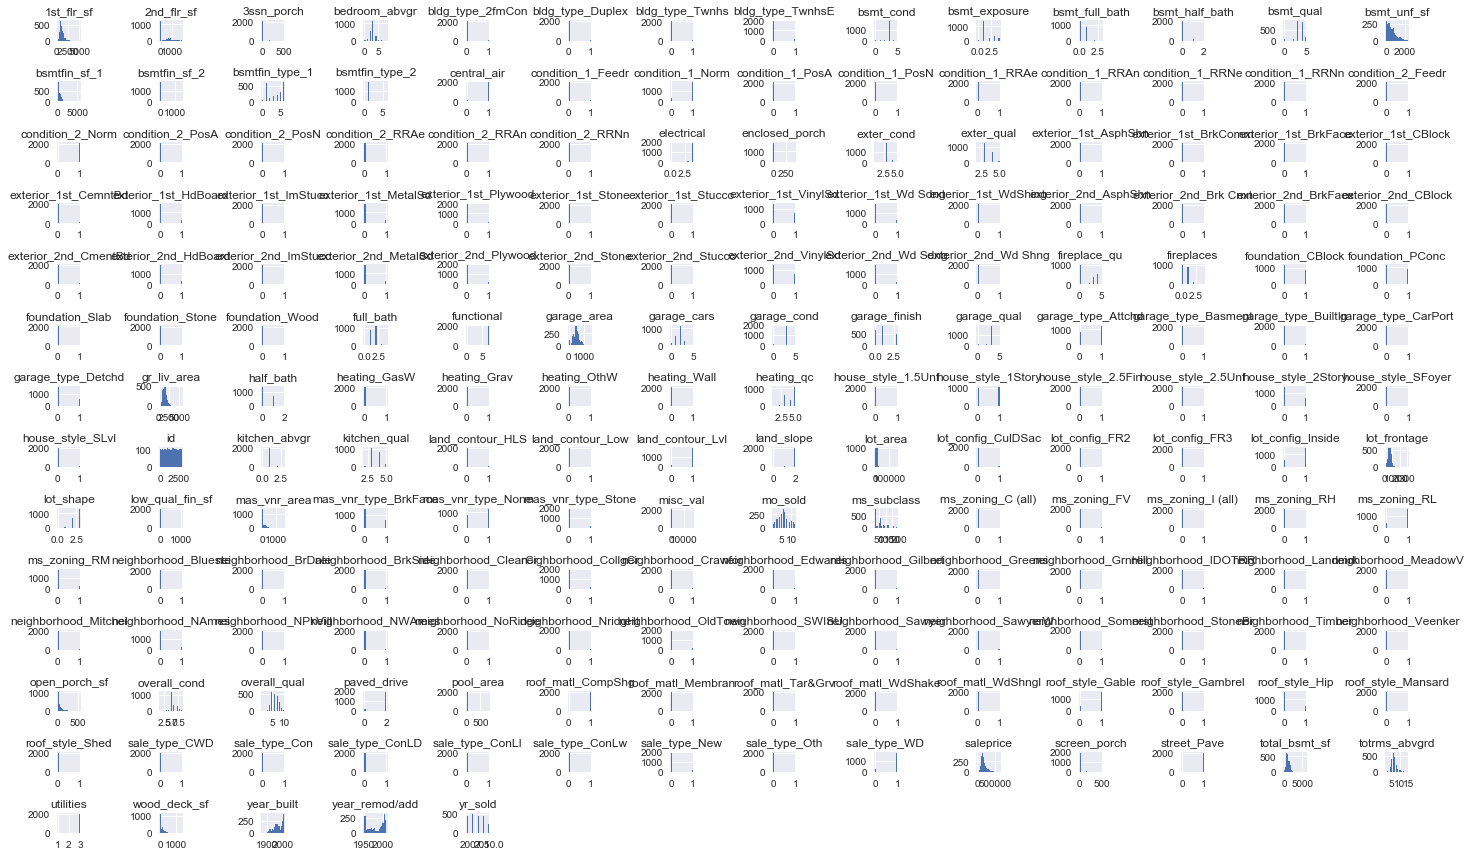

In [58]:
df.hist(figsize=(20, 12), bins = 20)
plt.tight_layout();

## Check correlations relative to target

In [59]:
corr_results = df.corr()[['saleprice']].sort_values('saleprice', ascending=False)
corr_filter = corr_results[abs(corr_results.saleprice > 0.6)]
corr_filter.index

Index(['saleprice', 'overall_qual', 'exter_qual', 'gr_liv_area',
       'kitchen_qual', 'garage_area', 'garage_cars', 'total_bsmt_sf',
       '1st_flr_sf', 'bsmt_qual'],
      dtype='object')

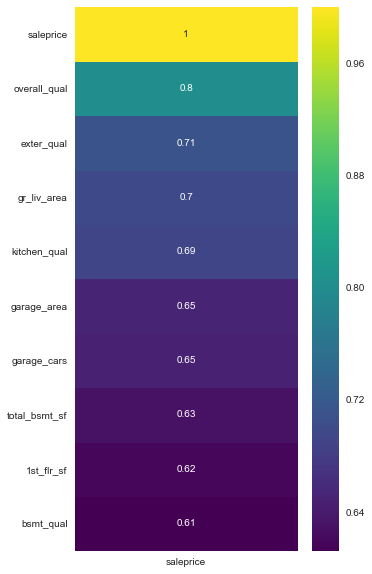

In [60]:
plt.figure(figsize=(5,10))
sns.heatmap(corr_filter, annot=True, cmap = 'viridis');

## Check correlations among the potential features
  
high correlations on:  
- garage_area AND garage_cars
- fireplaces AND fireplace_qu
- garage_yr_built AND year_built
- gr_live_area AND totrms_abvgrd

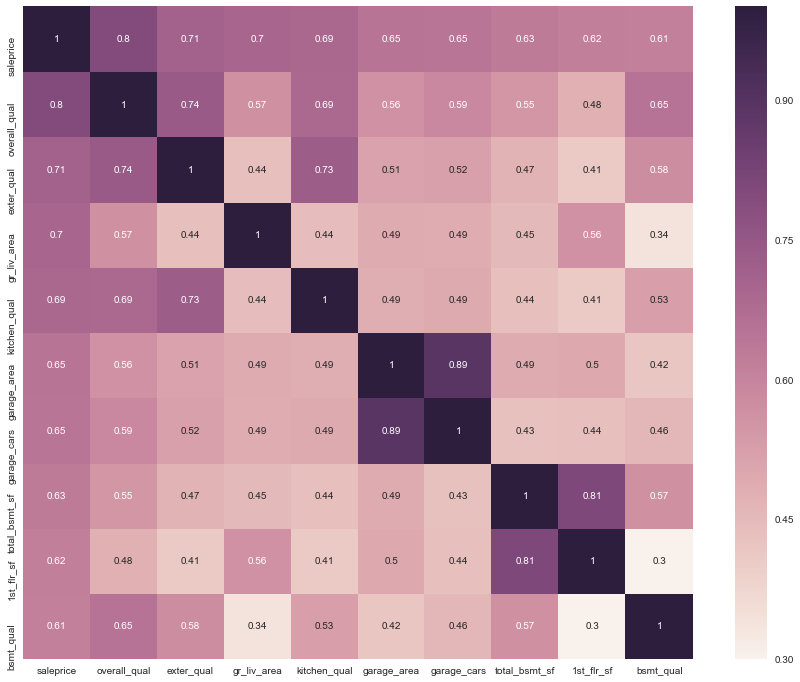

In [61]:
plt.figure(figsize = (15,12))
sns.heatmap(df[corr_filter.index].corr(), annot=True)

## Check for Outliers

/Users/kevinc/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


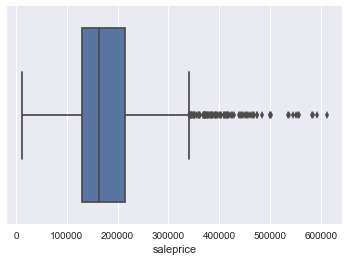

In [62]:
sns.boxplot(df.saleprice)

Looks like our target variable is skewed right.

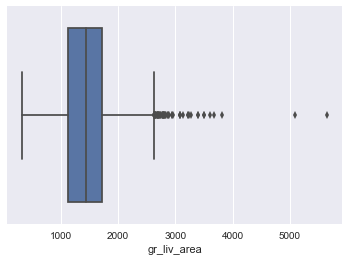

In [63]:
sns.boxplot(df.gr_liv_area)

Above-Grade Living Area, one of our main input variables, has a couple of significant outliers.

In [64]:
df[df.gr_liv_area > 5000]

id  ms_subclass  lot_frontage  lot_area  lot_shape  utilities  \
960   1499           60         313.0     63887          0          3   
1885  2181           20         128.0     39290          2          3   

      land_slope  overall_qual  overall_cond  year_built  ...  \
960            2            10             5        2008  ...   
1885           2            10             5        2008  ...   

      garage_type_CarPort  garage_type_Detchd  sale_type_CWD  sale_type_Con  \
960                     0                   0              0              0   
1885                    0                   0              0              0   

      sale_type_ConLD  sale_type_ConLI  sale_type_ConLw  sale_type_New  \
960                 0                0                0              1   
1885                0                0                0              1   

      sale_type_Oth  sale_type_WD   
960               0              0  
1885              0              0  

[2 rows x 187 columns]

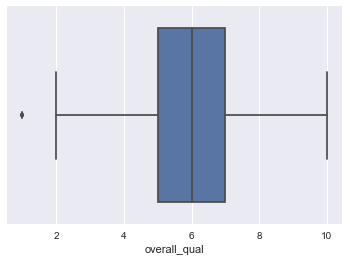

In [65]:
sns.boxplot(df.overall_qual)

A score of one on Overall Quality is an outlier.

In [66]:
df[df.overall_qual == 1]

id  ms_subclass  lot_frontage  lot_area  lot_shape  utilities  \
183   1554           20     80.000000     14584          3          3   
635   2904           20    125.000000     31250          3          3   
1372   766           30     60.921243     10020          2          3   
1428  1902           20     50.000000      5000          3          3   

      land_slope  overall_qual  overall_cond  year_built  ...  \
183            1             1             5        1952  ...   
635            2             1             3        1951  ...   
1372           0             1             1        1922  ...   
1428           1             1             3        1946  ...   

      garage_type_CarPort  garage_type_Detchd  sale_type_CWD  sale_type_Con  \
183                     0                   0              0              0   
635                     0                   0              0              0   
1372                    0                   0              0              0   
1428                    0                   0              0              0   

      sale_type_ConLD  sale_type_ConLI  sale_type_ConLw  sale_type_New  \
183                 0                0                0              0   
635                 0                0                0              0   
1372                0                0                0              0   
1428                0                0                0              0   

      sale_type_Oth  sale_type_WD   
183               0              1  
635               0              1  
1372              0              1  
1428              0              1  

[4 rows x 187 columns]

## Save cleaned datasets to new csv's

In [67]:
df.to_csv('../datasets/df_clean.csv')
holdout.to_csv('../datasets/holdout_clean.csv')